# Stock value prediction from Open, High, Low

# Import module

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
from pandas import DataFrame
from pandas import concat
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import pandas_datareader.data as web
import h5py
import os
import keras.backend as K
from keras.utils.generic_utils import get_custom_objects

Using TensorFlow backend.


# Input parameters 

In [2]:
stock_name = '^GSPC'
seq_len = 22
d = 0.2
shape = [4, seq_len, 1] # feature, window, output
neurons = [128, 128, 32, 1]
epochs = 10000

start = datetime.datetime(2013, 1, 1)
end = datetime.date.today()
neurons_layer = 1
optimizer = 'Adam'
# loss = 'mse'
loss = 'risk_estimation'

In [ ]:
def risk_estimation(y_true, y_pred):
    error_predict_index = y_true * y_pred <= 0
    err = y_true - y_pred
    err[error_predict_index] *= err[error_predict_index]
    
    return K.mean(err)

get_custom_objects().update({'risk_estimation': risk_estimation})

# 1. Download data and normalize it
Data since date 'start' to today

In [31]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  """
  函数用途：将时间序列转化为监督学习数据集。
  参数说明：
    data: 观察值序列，数据类型可以是 list 或者 NumPy array。
    n_in: 作为输入值(X)的滞后组的数量。
    n_out: 作为输出值(y)的观察组的数量。
    dropnan: Boolean 值，确定是否将包含 NaN 的行移除。
  返回值:
    经过转换的用于监督学习的 Pandas DataFrame 序列。
  """
  n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()
  # 输入序列 (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # 预测序列 (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # 将所有列拼合
  agg = concat(cols, axis=1)
  agg.columns = names
  # drop 掉包含 NaN 的行
  if dropnan:
    agg.dropna(inplace=True)
  return agg

raw = DataFrame()
raw['ob1'] = [x for x in range(10)]
# raw['ob2'] = [x for x in range(50, 60)]
values = raw.values
print(values)
data = series_to_supervised(values, 3, 1)
print(data)

[[0]
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]
 [9]]
   var1(t-3)  var1(t-2)  var1(t-1)  var1(t)
3        0.0        1.0        2.0        3
4        1.0        2.0        3.0        4
5        2.0        3.0        4.0        5
6        3.0        4.0        5.0        6
7        4.0        5.0        6.0        7
8        5.0        6.0        7.0        8
9        6.0        7.0        8.0        9


In [32]:
def get_stock_data(stock_name, normalize=True, use_exist_data=True):
    
    data_path = 'data/' + stock_name
    
    if use_exist_data and os.path.exists('data/' + stock_name):
        df = pd.read_csv(os.path.join(data_path))
        print ('read from local')
    else:
        df = web.DataReader(stock_name, "yahoo", start, end)
        df.to_csv(data_path)
        print ('read from remote')
    
    df.drop(['Volume', 'Close', 'Date'], 1, inplace=True)
    
    if normalize:
#         yesterday_value = pd.concat([df[:1], df[:len(df)-1]], ignore_index=True)
#         df = pd.concat([df[:]], istartgnore_index=True)
#         df = df / yesterday_value
        min_max_scaler = preprocessing.MinMaxScaler()
        for feature in df.columns:
            df[feature] = min_max_scaler.fit_transform(df[feature].values.reshape(-1,1))
    return df

In [33]:
df = get_stock_data(stock_name, normalize=True)

read from local


# 2. Plot out the Normalized Adjusted close price

In [34]:
def plot_stock(stock_name):
    df = get_stock_data(stock_name, normalize=True)
    print(df.head())
    plt.plot(df['Adj Close'], color='red', label='Adj Close')
    plt.legend(loc='best')
    plt.show()

read from local
       Open      High       Low  Adj Close
0  0.000000  0.000000  0.000000   0.000000
1  0.018415  0.028142  0.021804   0.028664
2  0.046494  0.030539  0.044587   0.026251
3  0.044130  0.032486  0.047274   0.031868
4  0.049633  0.031327  0.045434   0.028244


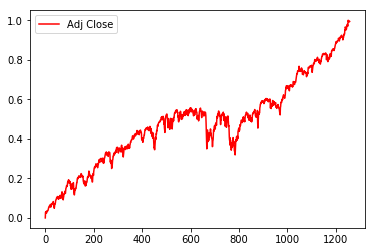

In [35]:
plot_stock(stock_name)

# 3. Set last day Adjusted Close as y

In [8]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    
    train = result[:int(row), :] # 90% date
    X_train = train[:, :-1] # all data until day m
    y_train = train[:, -1][:,-1] # day m + 1 adjusted close price
    
    X_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1] 

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

In [36]:
X_train, y_train, X_test, y_test = load_data(df, seq_len)

In [10]:
X_train.shape[0], X_train.shape[1], X_train.shape[2]

(1112, 22, 4)

In [11]:
y_train.shape[0]

1112

# 4. Buidling neural network

In [12]:
def build_model2(layers, neurons, d):
    model = Sequential()
    
    for i in range(neurons_layer):
        model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
            
    model.add(LSTM(neurons[1], input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='Tanh'))        
    # model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    # model = load_model('my_LSTM_stock_model1000.h5')
    # adam = keras.optimizers.Adam(decay=0.2)
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model

# 6. Model Execution

In [13]:
# model = build_model2(shape, neurons, d)
# # layers = [4, 22, 1]

In [14]:
# model.fit(
#     X_train,
#     y_train,
#     batch_size=512,
#     epochs=epochs,
#     validation_split=0.1,
#     verbose=1)

# 7. Result on training set and testing set

In [15]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

In [16]:
# model_score(model, X_train, y_train, X_test, y_test)

# 8. Prediction vs Real results

In [17]:
def percentage_difference(model, X_test, y_test):
    percentage_diff=[]

    p = model.predict(X_test)
    for u in range(len(y_test)): # for each data index in test data
        pr = p[u][0] # pr = prediction on day u

        percentage_diff.append((pr-y_test[u]/pr)*100)
    return percentage_diff

In [18]:
# p = percentage_difference(model, X_test, y_test)

# 9. Plot out prediction

In [19]:
def denormalize(stock_name, normalized_value):
    start = datetime.datetime(2000, 1, 1)
    end = datetime.date.today()
    
    df = get_stock_data(stock_name, normalize=False)
    df = df['Adj Close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

In [20]:
def plot_value(stock_name, predict, actual, dir_name, file_name):
    if not os.path.isdir(dir_name):
        os.makedirs(dir_name)
    
    fig_path = dir_name + '/' + file_name
    
    plt2.plot(predict, color='red', label='Prediction')
    plt2.plot(actual,color='blue', label='Actual')
    plt2.legend(loc='best')
    plt2.title('The test result for {}'.format(stock_name))
    plt2.xlabel('Days')
    plt2.ylabel('Adjusted Close')
    plt2.savefig(fig_path, format='png', bbox_inches='tight', transparent=True)
    plt2.close('all')

In [21]:
def plot_result(stock_name, normalized_value_p, normalized_value_y_test, epochs, date):
    newp = denormalize(stock_name, normalized_value_p)
    newy_test = denormalize(stock_name, normalized_value_y_test)    
    subdir = '/' +  date.strftime("%Y%m%d%H%M%S") + '/' + 'price' 
    dir_name = str(neurons_layer) + 'layer_' + optimizer + stock_name + '_' + start.strftime("%Y%m%d") + '-' + end.strftime("%Y%m%d") + subdir 
    figname = stock_name + '_epochs' + str(epochs) + '.png'
    plot_value(stock_name, newp, newy_test, dir_name, figname)

In [22]:
# plot_result(stock_name, p, y_test)

In [23]:
# 損益計算
def plot_value_change_and_revenue(stock_name, normalized_value_p, normalized_value_y_test, epochs, date):
    newp = denormalize(stock_name, normalized_value_p)
    newy_test = denormalize(stock_name, normalized_value_y_test)
    
    volumn_change_p = []
    volumn_change_y_test = []
    revenue_p = []
    revenue_y_test = []
    total_revenue_p = []
    total_revenue_y_test = []
    for i in range(len(newp)):
        if i == 0:
            volumn_change_p.append(0)
            volumn_change_y_test.append(0)
            
            revenue_p.append(0)
            revenue_y_test.append(0)
            
            total_revenue_p.append(0)
            total_revenue_y_test.append(0)
        else:
            volumn_change_p.append(newp[i] - newp[i-1])
            volumn_change_y_test.append(newy_test[i] - newy_test[i-1])

            if volumn_change_p[i] > volumn_change_p[i-1]:
                revenue_p.append(volumn_change_y_test[i] - volumn_change_y_test[i - 1])
            else:
                revenue_p.append(volumn_change_y_test[i - 1] - volumn_change_y_test[i])
            
            test_earn = abs(volumn_change_y_test[i] - volumn_change_y_test[i - 1])
            revenue_y_test.append(test_earn)
            
            total_revenue_p.append(total_revenue_p[i - 1] + revenue_p[i])
            total_revenue_y_test.append(total_revenue_y_test[i - 1] + revenue_y_test[i])
            
    figname = stock_name + '_epochs' + str(epochs) + '.png'
    
    subdir = '/' +  date.strftime("%Y%m%d%H%M%S") + '/' + 'value_change' 
    dir_name = str(neurons_layer) + 'layer_' + optimizer + stock_name + '_' + start.strftime("%Y%m%d") + '-' + end.strftime("%Y%m%d") + subdir
    plot_value(stock_name, volumn_change_p, volumn_change_y_test, dir_name, figname)
    
    subdir = '/' +  date.strftime("%Y%m%d%H%M%S") + '/' + 'revenue' 
    dir_name = str(neurons_layer) + 'layer_' + optimizer + stock_name + '_' + start.strftime("%Y%m%d") + '-' + end.strftime("%Y%m%d") + subdir
    plot_value(stock_name, revenue_p, revenue_y_test, dir_name, figname)
    
    subdir = '/' +  date.strftime("%Y%m%d%H%M%S") + '/' + 'revenue_sum' 
    dir_name = str(neurons_layer) + 'layer_' + optimizer + stock_name + '_' + start.strftime("%Y%m%d") + '-' + end.strftime("%Y%m%d") + subdir
    plot_value(stock_name, total_revenue_p, total_revenue_y_test, dir_name, figname)
    

# 10. Save for consistency

In [24]:
run_date = datetime.datetime.now()
save_plot_epochs = 25

model = build_model2(shape, neurons, d)
for i in range(int(epochs / save_plot_epochs)):
    model.fit(
        X_train,
        y_train,
        batch_size=512,
        epochs=save_plot_epochs,
        validation_split=0.1,
        verbose=1)
    predict_y = model.predict(X_test)
    plot_result(stock_name, predict_y, y_test, save_plot_epochs * (i + 1), run_date)
    plot_value_change_and_revenue(stock_name, predict_y, y_test, save_plot_epochs * (i + 1), run_date)
# model.save('LSTM_Stock_prediction-20170429.h5')



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 22, 128)           68096     
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 203,841
Trainable params: 203,841
Non-trainable params: 0
_________________________________________________________________
Trai

KeyboardInterrupt: 

In [ ]:
predict_y = model.predict(X_test)
